In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.image as mpimg 
from mpl_toolkits.basemap import Basemap
from scipy.interpolate import griddata
import numpy as np

from matplotlib.patches import Patch
import pickle
import pandas as pd
import networkx as nx

pd.set_option('display.max_rows', None)

In [2]:
with open('graph_objects/G_multi_directed_iggielgn.pickle', 'rb') as f:
    G_multi_directed = pickle.load(f)
    G_multi_directed.name = 'G_multi_directed'

In [ ]:
def find_num_paths_to_sinks(G, edge):
    u, v = edge
    count = 0
    paths = 0
    for node in G.nodes(data=True):
        data = node[1]
        flow_type = data['flow_type']
        if flow_type == 'sink':
            if nx.has_path(G, v, node[0]):
                paths += 1
        count += 1  
    return paths

# Define a function that finds number of paths from sources to the start of the edge
def find_num_paths_from_sources(G, edge):
    u, v = edge
    count = 0
    paths = 0
    for node in G.nodes(data=True):
        data = node[1]
        flow_type = data['flow_type']
        if flow_type == 'source':
            if nx.has_path(G, node[0], u):
                paths += 1
        count += 1  
    return paths


In [ ]:
paths_from_sources = find_num_paths_from_sources(G_multi_directed, ('SEQ_10361__M_LMGN','N_183_L_LMGN'))
paths_to_sinks = find_num_paths_to_sinks(G_multi_directed, ('SEQ_10361__M_LMGN','N_183_L_LMGN'))
print("Number of paths from sources to the start of the edge: ", paths_from_sources)
print("Number of paths from the edge to sinks: ", paths_to_sinks)
print()
paths_from_sources = find_num_paths_from_sources(G_multi_directed, ('SEQ_369__L_LMGN', 'SEQ_373__L_LMGN'))
paths_to_sinks = find_num_paths_to_sinks(G_multi_directed, ('SEQ_369__L_LMGN', 'SEQ_373__L_LMGN'))
print("Number of paths from sources to the start of the edge: ", paths_from_sources)
print("Number of paths from the edge to sinks: ", paths_to_sinks)
print()
paths_from_sources = find_num_paths_from_sources(G_multi_directed, ('SEQ_8285__L_LMGN','SEQ_2025__L_LMGN'))
paths_to_sinks = find_num_paths_to_sinks(G_multi_directed, ('SEQ_8285__L_LMGN','SEQ_2025__L_LMGN'))
print("Number of paths from sources to the start of the edge: ", paths_from_sources)
print("Number of paths from the edge to sinks: ", paths_to_sinks)
print()
paths_from_sources = find_num_paths_from_sources(G_multi_directed, ('N_539_M_LMGN','SEQ_7053__M_LMGN'))
paths_to_sinks = find_num_paths_to_sinks(G_multi_directed, ('N_539_M_LMGN','SEQ_7053__M_LMGN'))
print("Number of paths from sources to the start of the edge: ", paths_from_sources)
print("Number of paths from the edge to sinks: ", paths_to_sinks)

"""
Output:

Number of paths from sources to the start of the edge:  25
Number of paths from the edge to sinks:  24

Number of paths from sources to the start of the edge:  25
Number of paths from the edge to sinks:  24

Number of paths from sources to the start of the edge:  25
Number of paths from the edge to sinks:  24

Number of paths from sources to the start of the edge:  22
Number of paths from the edge to sinks:  312
"""

In [ ]:
import networkx as nx
from collections import defaultdict

# Define a function that creates a histogram of the number of paths to sinks for all nodes
def find_path_histogram_to_sinks(G):
    path_counts = defaultdict(int)
    
    count  = 0
    for target in G.nodes():

        # Skip target if its out-degree is 0
        if G.out_degree(target) == 0:
            continue

        num_paths = 0
        for node, data in G.nodes(data=True):
            if data['flow_type'] == 'sink':
                if nx.has_path(G, target, node):
                    num_paths += len(list(nx.all_shortest_paths(G, target, node)))
        path_counts[num_paths] += 1
        count += 1
                
    return dict(path_counts)

# Define a function that creates a histogram of the number of paths from sources for all nodes
def find_path_histogram_from_sources(G):
    path_counts = defaultdict(int)

    count=0
    for target in G.nodes():
         # Skip target if its in-degree is 0
        if G.in_degree(target) == 0:
            continue
        
        num_paths = 0
        for node, data in G.nodes(data=True):
            if data['flow_type'] == 'source':
                if nx.has_path(G, node, target):
                    num_paths += len(list(nx.all_shortest_paths(G, node, target)))
        path_counts[num_paths] += 1
        count += 1
                
    return dict(path_counts)

In [ ]:
to_sinks_histogram = find_path_histogram_to_sinks(G_multi_directed)
from_sources_histogram = find_path_histogram_from_sources(G_multi_directed)

In [ ]:
def calculate_median(path_counts):
    total_elements = sum(path_counts.values())
    median_index = total_elements // 2
    
    sorted_keys = sorted(path_counts.keys())
    
    cumulative_sum = 0
    median_values = []
    
    for key in sorted_keys:
        cumulative_sum += path_counts[key]
        if cumulative_sum >= median_index:
            median_values.append(key)
            if total_elements % 2 == 0 and cumulative_sum >= median_index + 1:
                # If the total number of elements is even, get the next value for the second median
                median_values.append(key)
            break
    
    if len(median_values) == 1:
        return median_values[0]
    else:
        return sum(median_values) / 2.0

In [ ]:
def edge_betweenness_centrality_stats(G, specific_edges):
    """
    Compute the median and average betweenness centrality of all edges in the graph G.
    Also print betweenness centrality of the specified edges in specific_edges.

    Parameters:
    G (networkx.Graph): The input graph.
    specific_edges (list): List of edges (tuples) for which to print the betweenness centrality.

    Returns:
    tuple: (median_betweenness, average_betweenness)
    """
    # Compute edge betweenness centrality for all edges
    edge_betweenness = nx.edge_betweenness_centrality(G, weight='max_cap_M_m3_per_d')
    edge_betweenness = { (u, v): bc for (u, v, _), bc in edge_betweenness.items() }

    
    # Get the betweenness centrality values
    betweenness_values = list(edge_betweenness.values())
    
    # Compute median and average betweenness centrality
    median_betweenness = np.median(betweenness_values)
    average_betweenness = np.mean(betweenness_values)
    

    print(edge_betweenness)
    # Print betweenness centrality of the specified edges
    for edge in specific_edges:
        if edge in edge_betweenness:
            print(f"Betweenness centrality for edge {edge}: {edge_betweenness[edge]}")
        else:
            print(f"Edge {edge} is not in the graph.")
    
    return median_betweenness, average_betweenness

In [ ]:
median_betweenness, average_betweenness = edge_betweenness_centrality_stats(G_multi_directed, common_edges)

"""
Betweenness centrality for edge ('N_539_M_LMGN', 'SEQ_7053__M_LMGN'): 4.85e-03
Betweenness centrality for edge ('SEQ_8285__L_LMGN', 'SEQ_2025__L_LMGN'): 1.64e-03
Betweenness centrality for edge ('SEQ_369__L_LMGN', 'SEQ_373__L_LMGN'): 1.11e-03
Betweenness centrality for edge ('SEQ_10361__M_LMGN', 'N_183_L_LMGN'): 1.49e-03

Median Betweenness Centrality: 1.60e-05
Average Betweenness Centrality: 4.91e-04
"""

In [ ]:
median_to_sinks = calculate_median(to_sinks_histogram)
median_from_sources = calculate_median(from_sources_histogram)

""" 
Output: (6.0, 3)
"""
median_to_sinks, median_from_sources

----

In [ ]:
top_5_FC_edges = pd.read_pickle('results/max_flow/iggielgn/hybrid/FC_edge_removal_df.pkl').iloc[1:6]
top_5_FC_edges['removed_entity'] = top_5_FC_edges['removed_entity'].apply(lambda edge: tuple(edge))

top_5_FCR_edges = pd.read_pickle('results/max_flow/iggielgn/hybrid/FCR_edge_removal_df.pkl').iloc[1:6]
top_5_FCR_edges['removed_entity'] = top_5_FCR_edges['removed_entity'].apply(lambda edge: tuple(edge))

top_5_WFCR_edges = pd.read_pickle('results/max_flow/iggielgn/hybrid/WFCR_edge_removal_df.pkl').iloc[1:6]
top_5_WFCR_edges['removed_entity'] = top_5_WFCR_edges['removed_entity'].apply(lambda edge: tuple(edge))

In [ ]:
for i, edge in top_5_FC_edges.iterrows():
    if edge['removed_entity'] not in G_multi_directed.edges():
        # Reverse the edge
        reversed_edge = (edge['removed_entity'][1], edge['removed_entity'][0])
        
        # Update the dataframe
        top_5_FC_edges.at[i, 'removed_entity'] = reversed_edge



for i, edge in top_5_FCR_edges.iterrows():
    if edge['removed_entity'] not in G_multi_directed.edges():
        # Reverse the edge
        reversed_edge = (edge['removed_entity'][1], edge['removed_entity'][0])
        
        # Update the dataframe
        top_5_FCR_edges.at[i, 'removed_entity'] = reversed_edge

for i, edge in top_5_WFCR_edges.iterrows():
    if edge['removed_entity'] not in G_multi_directed.edges():
        # Reverse the edge
        reversed_edge = (edge['removed_entity'][1], edge['removed_entity'][0])
        
        # Update the dataframe
        top_5_WFCR_edges.at[i, 'removed_entity'] = reversed_edge


print(top_5_FC_edges[['removed_entity', 'capacity_robustness_max_flow']])
print(top_5_FCR_edges[['removed_entity', 'capacity_robustness_max_flow']])
print(top_5_WFCR_edges[['removed_entity', 'capacity_robustness_max_flow']])

In [ ]:
# For each of the top 5 edges removed in each of the three scenarios, plot the edges on a map of europe and label the edge
plt.figure(figsize=(9, 10))
m = Basemap(projection='merc', llcrnrlat=30, urcrnrlat=69, llcrnrlon=-15, urcrnrlon=60, resolution='l')
m.drawcoastlines()
m.drawcountries()
m.fillcontinents(color='lightgray')


for i, edge in top_5_FC_edges.iterrows():
    u, v = edge['removed_entity']
    x, y = m([G_multi_directed.nodes[u]['long'], G_multi_directed.nodes[v]['long']], [G_multi_directed.nodes[u]['lat'], G_multi_directed.nodes[v]['lat']])
    m.plot(x, y, 'orange', linewidth=5)

    # Highlight the source and destination nodes
    # m.scatter(x[0], y[0], c='red', marker='o', s=100)
    # m.scatter(x[1], y[1], c='green', marker='o', s=100)
    
    plt.text(x[0], y[0], f'{u} -> {v}', fontsize=10, color='orange')

plt.legend(loc='upper left', fontsize=15)
plt.show()

plt.figure(figsize=(9, 10))
m = Basemap(projection='merc', llcrnrlat=30, urcrnrlat=69, llcrnrlon=-15, urcrnrlon=60, resolution='l')
m.drawcoastlines()
m.drawcountries()
m.fillcontinents(color='lightgray')

for i, edge in top_5_FCR_edges.iterrows():
    u, v = edge['removed_entity']
    x, y = m([G_multi_directed.nodes[u]['long'], G_multi_directed.nodes[v]['long']], [G_multi_directed.nodes[u]['lat'], G_multi_directed.nodes[v]['lat']])
    m.plot(x, y, 'g-', linewidth=5)

    # Highlight the source and destination nodes
    # m.scatter(x[0], y[0], c='red', marker='o', s=100)
    # m.scatter(x[1], y[1], c='green', marker='o', s=100)
    
    plt.text(x[0], y[0], f'{u} -> {v}', fontsize=8, color='green', bbox=dict(boxstyle="round,pad=0.5", edgecolor="black", facecolor="white"))

plt.legend(loc='upper left', fontsize=15)
plt.show()

plt.figure(figsize=(9, 10))
m = Basemap(projection='merc', llcrnrlat=30, urcrnrlat=69, llcrnrlon=-15, urcrnrlon=60, resolution='l')
m.drawcoastlines()
m.drawcountries()
m.fillcontinents(color='lightgray')

for i, edge in top_5_WFCR_edges.iterrows():
    u, v = edge['removed_entity']
    x, y = m([G_multi_directed.nodes[u]['long'], G_multi_directed.nodes[v]['long']], [G_multi_directed.nodes[u]['lat'], G_multi_directed.nodes[v]['lat']])
    m.plot(x, y, 'r-', linewidth=5)    

    # Highlight the source and destination nodes
    # m.scatter(x[0], y[0], c='red', marker='o', s=100)
    # m.scatter(x[1], y[1], c='green', marker='o', s=100)





    plt.text(x[0], y[0], f'{u} -> {v}', fontsize=10, color='red')

plt.legend(loc='upper left', fontsize=15)
plt.show()


## FCR plateau observed in removal plot

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import pickle

In [ ]:
with open('graph_objects/G_multi_directed_iggielgn.pickle', 'rb') as f:
    G_multi_directed = pickle.load(f)
    G_multi_directed.name = 'G_multi_directed'

In [ ]:
FC_edges = pd.read_pickle('results/max_flow/iggielgn/hybrid/FC_edge_removal_df.pkl').iloc[1:12]
FCR_edges = pd.read_pickle('results/max_flow/iggielgn/hybrid/FCR_edge_removal_df.pkl').iloc[1:12]
WFCR_edges = pd.read_pickle('results/max_flow/iggielgn/hybrid/WFCR_edge_removal_df.pkl').iloc[1:12]

# Plot the top 10 removals for each scenario with iterations on x-axis and flow_robustness_capacity on y-axis
plt.figure(figsize=(10, 6))
plt.plot(FC_edges.index, FC_edges['capacity_robustness_max_flow'], label='FC', marker='o')
plt.plot(FCR_edges.index, FCR_edges['capacity_robustness_max_flow'], label='FCR', marker='o')
plt.plot(WFCR_edges.index, WFCR_edges['capacity_robustness_max_flow'], label='WFCR', marker='o')
plt.xlabel('Iteration')
plt.ylabel('Flow Capacity')
plt.legend()
plt.show()

In [ ]:
print('FC', FC_edges.head(7)[['removed_entity', 'capacity_robustness_max_flow']])
print('FCR',FCR_edges.head(11)[['removed_entity', 'capacity_robustness_max_flow']])
print('WFCR', WFCR_edges.head(10)[['removed_entity', 'capacity_robustness_max_flow']])

In [ ]:

plt.figure(figsize=(9, 10))
m = Basemap(projection='merc', llcrnrlat=30, urcrnrlat=69, llcrnrlon=-15, urcrnrlon=60, resolution='l')
m.drawcoastlines()
m.drawcountries()
m.fillcontinents(color='lightgray')


u, v = ('LKD_N_199', 'LKD_N_104')
x, y = m([G_multi_directed.nodes[u]['long'], G_multi_directed.nodes[v]['long']], [G_multi_directed.nodes[u]['lat'], G_multi_directed.nodes[v]['lat']])
m.plot(x, y, 'blue', linewidth=5)
plt.text(x[0], y[0], f'{u} -> {v}', fontsize=10, color='blue')

u, v =  ('N_272_M_LMGN', 'SEQ_10351__M_LMGN')
x, y = m([G_multi_directed.nodes[u]['long'], G_multi_directed.nodes[v]['long']], [G_multi_directed.nodes[u]['lat'], G_multi_directed.nodes[v]['lat']])
m.plot(x, y, 'red', linewidth=5)
plt.text(x[0], y[0], f'{u} -> {v}', fontsize=10, color='red')

plt.legend(loc='upper left', fontsize=15)
plt.show()

In [ ]:
# Print the number of edges between  {N_183_L_LMGN, SEQ_10361__M_LMGN} in G_multi_directed
print(G_multi_directed.number_of_edges('SEQ_10361__M_LMGN', 'N_183_L_LMGN'))

# Determine the direction of the edge between {N_183_L_LMGN, SEQ_10361__M_LMGN}
print(G_multi_directed['SEQ_10361__M_LMGN']['N_183_L_LMGN'])

# {SEQ_614_p, INET_N_329} {N_193_M_LMGN, SEQ_2025_p} 
print(G_multi_directed.number_of_edges('SEQ_614_p', 'INET_N_329'))
print(G_multi_directed.number_of_edges('N_193_M_LMGN', 'SEQ_2025_p'))

print(G_multi_directed['SEQ_614_p']['INET_N_329'])
print(G_multi_directed['N_193_M_LMGN']['SEQ_2025_p'])



{0: {'id': 'LKD_PS_266_Seg_0_Seg_0', 'name': 'LKD_PS_266_Seg_0_Seg_0', 'source_id': "['LKD_385']", 'comment': nan, 'tags': '{}', 'diameter_mm': 700.0, 'end_year': None, 'is_H_gas': 1, 'is_bothDirection': 0, 'lat_mean': 53.204709, 'length_km': 22.632064, 'long_mean': 7.453424, 'max_cap_M_m3_per_d': 15.840280693066717, 'max_pressure_bar': 70.0, 'nuts_id_1': "['DE9', 'DE9']", 'nuts_id_2': "['DE94', 'DE94']", 'nuts_id_3': "['DE94C', 'DE94C']", 'path_lat': '[53.173529]', 'path_long': '[7.451287]', 'start_year': nan, 'uncertainty_diameter_mm': 0.0, 'uncertainty_end_year': nan, 'uncertainty_is_H_gas': 0.0, 'uncertainty_is_bothDirection': 0.5, 'uncertainty_lat_mean': 0.050511000000000195, 'uncertainty_length_km': 0.3333333333333333, 'uncertainty_long_mean': 0.13014699999999998, 'uncertainty_max_cap_M_m3_per_d': 0.0, 'uncertainty_max_pressure_bar': 0.0, 'uncertainty_nuts_id_1': 0.0, 'uncertainty_nuts_id_2': 0.0, 'uncertainty_nuts_id_3': 0.0, 'uncertainty_path_lat': 0.0, 'uncertainty_path_long': 0.0, 'uncertainty_start_year': nan, 'method_diameter_mm': 'raw', 'method_end_year': None, 'method_is_H_gas': 'raw', 'method_is_bothDirection': 'make_Attrib(const)', 'method_lat_mean': 'make_Attrib(latlong_mean)', 'method_length_km': 'fill_length(PipeSegments)', 'method_long_mean': 'make_Attrib(latlong_mean)', 'method_max_cap_M_m3_per_d': 'log_raw', 'method_max_pressure_bar': 'raw', 'method_nuts_id_1': 'make_Attrib(const)', 'method_nuts_id_2': 'make_Attrib(const)', 'method_nuts_id_3': 'make_Attrib(const)', 'method_path_lat': 'K_Netze.make_path_latlong(lat)', 'method_path_long': 'K_Netze.make_path_latlong(lat)', 'method_start_year': None, 'from_node_id': 'LKD_N_199', 'to_node_id': 'LKD_N_104', 'from_country_code': 'DE', 'to_country_code': 'DE', 'from_lat': 53.169788, 'to_lat': 53.27081, 'from_long': 7.584639, 'to_long': 7.324345}, 


1: {'id': 'LKD_PS_300_Seg_0_Seg_0', 'name': 'LKD_PS_300_Seg_0_Seg_0', 'source_id': "['LKD_419']", 'comment': nan, 'tags': '{}', 'diameter_mm': 1000.0, 'end_year': None, 'is_H_gas': 0, 'is_bothDirection': 0, 'lat_mean': 53.204833, 'length_km': 24.787585, 'long_mean': 7.425259, 'max_cap_M_m3_per_d': 61.37956396400001, 'max_pressure_bar': 70.0, 'nuts_id_1': "['DE9', 'DE9']", 'nuts_id_2': "['DE94', 'DE94']", 'nuts_id_3': "['DE94C', 'DE94C']", 'path_lat': '[53.181582, 53.197152]', 'path_long': '[7.450721, 7.341333]', 'start_year': nan, 'uncertainty_diameter_mm': 0.0, 'uncertainty_end_year': nan, 'uncertainty_is_H_gas': 0.0, 'uncertainty_is_bothDirection': 0.5, 'uncertainty_lat_mean': 0.050511000000000195, 'uncertainty_length_km': 0.25, 'uncertainty_long_mean': 0.13014699999999998, 'uncertainty_max_cap_M_m3_per_d': 0.0, 'uncertainty_max_pressure_bar': 0.0, 'uncertainty_nuts_id_1': 0.0, 'uncertainty_nuts_id_2': 0.0, 'uncertainty_nuts_id_3': 0.0, 'uncertainty_path_lat': 0.0, 'uncertainty_path_long': 0.0, 'uncertainty_start_year': nan, 'method_diameter_mm': 'raw', 'method_end_year': None, 'method_is_H_gas': 'raw', 'method_is_bothDirection': 'make_Attrib(const)', 'method_lat_mean': 'make_Attrib(latlong_mean)', 'method_length_km': 'fill_length(PipeSegments)', 'method_long_mean': 'make_Attrib(latlong_mean)', 'method_max_cap_M_m3_per_d': 'log_raw', 'method_max_pressure_bar': 'raw', 'method_nuts_id_1': 'make_Attrib(const)', 'method_nuts_id_2': 'make_Attrib(const)', 'method_nuts_id_3': 'make_Attrib(const)', 'method_path_lat': 'K_Netze.make_path_latlong(lat)', 'method_path_long': 'K_Netze.make_path_latlong(lat)', 'method_start_year': None, 'from_node_id': 'LKD_N_199', 'to_node_id': 'LKD_N_104', 'from_country_code': 'DE', 'to_country_code': 'DE', 'from_lat': 53.169788, 'to_lat': 53.27081, 'from_long': 7.584639, 'to_long': 7.324345}}

In [ ]:
# Print the number of edges between  'N_272_M_LMGN' and 'SEQ_10351__M_LMGN' in G_multi_directed
print(G_multi_directed.number_of_edges('N_272_M_LMGN', 'SEQ_10351__M_LMGN'))

# Determine the direction of the edge between 'N_272_M_LMGN' and 'SEQ_10351__M_LMGN'
print(G_multi_directed['N_272_M_LMGN']['SEQ_10351__M_LMGN'])

{0: {'id': 'PLM_2402_Seg_0_Seg_0', 'name': 'PLM_2402_Seg_0_Seg_0', 'source_id': "['EntsoG_Map_69008']", 'comment': nan, 'tags': '{}', 'diameter_mm': 900.0, 'end_year': None, 'is_H_gas': 1, 'is_bothDirection': 0, 'lat_mean': 54.008605, 'length_km': 51.786549, 'long_mean': 38.72301, 'max_cap_M_m3_per_d': 27.809143341935314, 'max_pressure_bar': 70.0, 'nuts_id_1': "['RU', 'RU']", 'nuts_id_2': "['RU', 'RU']", 'nuts_id_3': "['RU', 'RU']", 'path_lat': '[54.0433, 53.98531]', 'path_long': '[38.77488, 38.59299]', 'start_year': nan, 'uncertainty_diameter_mm': 249.87054361567627, 'uncertainty_end_year': nan, 'uncertainty_is_H_gas': 0.5, 'uncertainty_is_bothDirection': 0.5, 'uncertainty_lat_mean': 0.10955500000000029, 'uncertainty_length_km': 0.25, 'uncertainty_long_mean': 0.3436850000000007, 'uncertainty_max_cap_M_m3_per_d': 24.306462524672494, 'uncertainty_max_pressure_bar': 11.06611831401779, 'uncertainty_nuts_id_1': 0.0, 'uncertainty_nuts_id_2': 0.0, 'uncertainty_nuts_id_3': 0.0, 'uncertainty_path_lat': 0.0, 'uncertainty_path_long': 0.0, 'uncertainty_start_year': nan, 'method_diameter_mm': 'Median(diameter_mm)', 'method_end_year': None, 'method_is_H_gas': 'make_Attrib(const)', 'method_is_bothDirection': 'make_Attrib(const)', 'method_lat_mean': 'make_Attrib(latlong_mean)', 'method_length_km': 'fill_length(PipeSegments)', 'method_long_mean': 'make_Attrib(latlong_mean)', 'method_max_cap_M_m3_per_d': 'Median(max_cap_M_m3_per_d)', 'method_max_pressure_bar': 'Median(max_pressure_bar)', 'method_nuts_id_1': 'make_Attrib(const)', 'method_nuts_id_2': 'make_Attrib(const)', 'method_nuts_id_3': 'make_Attrib(const)', 'method_path_lat': 'K_Netze.make_path_latlong(lat)', 'method_path_long': 'K_Netze.make_path_latlong(lat)', 'method_start_year': None, 'from_node_id': 'N_272_M_LMGN', 'to_node_id': 'SEQ_10351__M_LMGN', 'from_country_code': 'RU', 'to_country_code': 'RU', 'from_lat': 54.11246, 'to_lat': 53.89335, 'from_long': 39.10577, 'to_long': 38.4184}}

In [ ]:
# Plot all Russian nodes and edges on a map of Eastern Europe. Highlight the nodes 'N_272_M_LMGN' and 'SEQ_10351__M_LMGN'
plt.figure(figsize=(9, 10))

m = Basemap(projection='merc',
            llcrnrlat=50,  # Lower-left corner latitude
            urcrnrlat=60,  # Upper-right corner latitude
            llcrnrlon=25,  # Lower-left corner longitude
            urcrnrlon=50,  # Upper-right corner longitude
            resolution='l')
m.drawcoastlines()
m.drawcountries()
m.fillcontinents(color='lightgray')

# Plot the points themselves
lats = [G_multi_directed.nodes[node]['lat'] for node in G_multi_directed.nodes() if 'RU' in node]
lons = [G_multi_directed.nodes[node]['long'] for node in G_multi_directed.nodes() if 'RU' in node]
x, y = m(lons, lats)
m.scatter(x, y, c='black', marker='o', s=10, alpha=0.1)

# Plot the all the edges in G_multi_directed
for u, v in G_multi_directed.edges():
    x, y = m([G_multi_directed.nodes[u]['long'], G_multi_directed.nodes[v]['long']], [G_multi_directed.nodes[u]['lat'], G_multi_directed.nodes[v]['lat']])
    m.plot(x, y, 'k-', alpha=0.2)
    

# Highlight the source and destination nodes
u, v =  ('N_272_M_LMGN', 'SEQ_10351__M_LMGN')
x, y = m([G_multi_directed.nodes[u]['long'], G_multi_directed.nodes[v]['long']], [G_multi_directed.nodes[u]['lat'], G_multi_directed.nodes[v]['lat']])
m.plot(x, y, 'red', linewidth=2)
plt.text(x[0], y[0], f'{u} -> {v}', fontsize=10, color='red')

plt.legend(loc='upper left', fontsize=15)
plt.show()


In [ ]:
russian_node_ids = [node[0] for node in G_multi_directed.nodes(data=True) if node[1]['country_code'] == 'RU']
G_Russia = G_multi_directed.subgraph(russian_node_ids)

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import FancyArrowPatch

# Plot all Russian nodes and edges on a map of Eastern Europe. Highlight the nodes 'N_272_M_LMGN' and 'SEQ_10351__M_LMGN'
plt.figure(figsize=(9, 10))

m = Basemap(projection='merc',
            llcrnrlat=52,  # Lower-left corner latitude, increase for Northward direction
            urcrnrlat=56,  # Upper-right corner latitude, decrease for Southward direction
            llcrnrlon=32,  # Lower-left corner longitude, incrase for Eastward direction
            urcrnrlon=45,  # Upper-right corner longitude, decrese for Westward direction
            resolution='l')
m.drawcoastlines()
m.drawcountries()
m.fillcontinents(color='lightgray')

# Plot the points themselves
lats = [node[1]['lat'] for node in G_Russia.nodes(data=True)]
lons = [node[1]['long'] for node in G_Russia.nodes(data=True)]
x, y = m(lons, lats)
m.scatter(x, y, c='black', marker='o', s=10)

# Plot all the edges in G_Russia
for u, v in G_Russia.edges():
    x_start, y_start = m(G_Russia.nodes[u]['long'], G_Russia.nodes[u]['lat'])
    x_end, y_end = m(G_Russia.nodes[v]['long'], G_Russia.nodes[v]['lat'])
    m.plot([x_start, x_end], [y_start, y_end], 'k-', alpha=0.2)
    arrow = FancyArrowPatch((x_start, y_start), (x_end, y_end),
                            arrowstyle='->', color='black', linewidth=1, mutation_scale=8)  # Increased mutation_scale for larger arrows
    plt.gca().add_patch(arrow)

# Highlight the source and destination nodes
u, v = ('N_272_M_LMGN', 'SEQ_10351__M_LMGN')
x_start, y_start = m(G_Russia.nodes[u]['long'], G_Russia.nodes[u]['lat'])
x_end, y_end = m(G_Russia.nodes[v]['long'], G_Russia.nodes[v]['lat'])
m.plot([x_start, x_end], [y_start, y_end], 'red', linewidth=2)
arrow = FancyArrowPatch((x_start, y_start), (x_end, y_end),
                        arrowstyle='->', color='red', linewidth=1.5, mutation_scale=8)  # Increased mutation_scale for highlighted arrow
plt.gca().add_patch(arrow)
plt.text(x_start, y_start, f'{u} -> {v}', fontsize=10, color='red')

plt.legend(loc='upper left', fontsize=15)
plt.show()


----

In [ ]:
edges_to_plot = pd.read_pickle('results/comparison/centrality_greedily_removed_edges_max_flow_df.pkl').iloc[16:26].removed_entity.values
edges_to_plot = [tuple(edge) for edge in edges_to_plot]
print(edges_to_plot)


def plot_edge(edges):

    plt.figure(figsize=(9, 10))
    m = Basemap(projection='merc', llcrnrlat=30, urcrnrlat=69, llcrnrlon=-15, urcrnrlon=60, resolution='l')
    m.drawcoastlines()
    m.drawcountries()
    m.fillcontinents(color='lightgray')

    for edge in edges:
        u, v = edge
        x, y = m([G_multi_directed.nodes[u]['long'], G_multi_directed.nodes[v]['long']], [G_multi_directed.nodes[u]['lat'], G_multi_directed.nodes[v]['lat']])
        m.plot(x, y, 'blue', linewidth=5)
        plt.text(x[0], y[0], f'{u} -> {v}', fontsize=10, color='blue')
    
plot_edge(edges_to_plot)



In [ ]:
edges_to_plot = pd.read_pickle('results/comparison/centrality_greedily_removed_edges_max_flow_df.pkl').iloc[1:6].removed_entity.values
edges_to_plot = [tuple(edge) for edge in edges_to_plot]
print(edges_to_plot)


def plot_edge(edges):

    plt.figure(figsize=(9, 10))
    m = Basemap(projection='merc', llcrnrlat=30, urcrnrlat=69, llcrnrlon=-15, urcrnrlon=60, resolution='l')
    m.drawcoastlines()
    m.drawcountries()
    m.fillcontinents(color='lightgray')

    for edge in edges:
        u, v = edge
        x, y = m([G_multi_directed.nodes[u]['long'], G_multi_directed.nodes[v]['long']], [G_multi_directed.nodes[u]['lat'], G_multi_directed.nodes[v]['lat']])
        m.plot(x, y, 'blue', linewidth=5)
        plt.text(x[0], y[0], f'{u} -> {v}', fontsize=10, color='blue')
    
plot_edge(edges_to_plot)



In [ ]:
with open('graph_objects/G_simple_directed_iggielgn.pickle', 'rb') as f:
    G_simple_directed = pickle.load(f)
    G_simple_directed.name = 'G_simple_directed'
for edge in edges_to_plot:
    print(edge in G_simple_directed.edges())

In [ ]:
# For each of the edges in edges_to_plot, provide information obout the number of parallell edges between the connecting nodesand the direction of the edge
for edge in edges_to_plot:
    if edge in G_multi_directed.edges():
        print('Normal')
        print(G_multi_directed.number_of_edges(edge[0], edge[1]))

    if (edge[1], edge[0]) in G_multi_directed.edges():
        print('Reversed')
        print(G_multi_directed.number_of_edges(edge[1], edge[0]))


----

# Heatmaps

In [ ]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from scipy.interpolate import griddata

In [ ]:
with open('graph_objects/G_simple_directed_iggielgn.pickle', 'rb') as f:
    G_simple_directed = pickle.load(f)
    G_simple_directed.name = 'G_simple_directed'

In [ ]:
# Analysis; 'centrality' or 'max_flow'
analysis = 'centrality'

In [ ]:
node_removals_df = pd.read_pickle('results/max_flow/iggielgn/hybrid/wfcr_node_removal_df.pkl')
if analysis == 'centrality':
    node_removals_df = pd.read_pickle('results/centrality/iggielgn/greedy_node_removal.pkl').head(100)

### Node heatmap

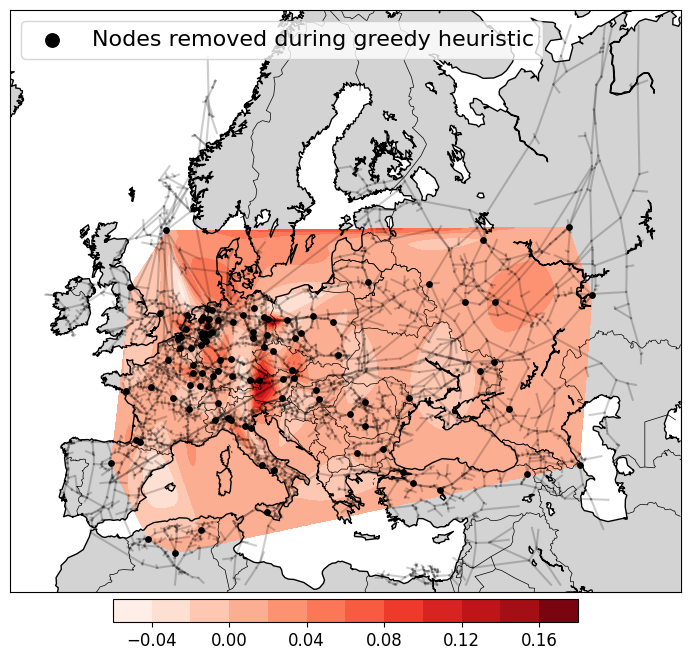

In [ ]:
metric = 'capacity_robustness_max_flow'
if analysis == 'centrality':
    metric = 'NPI'

df = node_removals_df.copy()
df[metric+'_diff'] = df[metric].diff().abs()

# Get the latitude and longitude of nodes present in the DataFrame
df = df.iloc[1:]

nodes_in_df = df['removed_entity'].values
lats = [G_simple_directed.nodes[node]['lat'] for node in nodes_in_df if node in G_simple_directed.nodes()]
lons = [G_simple_directed.nodes[node]['long'] for node in nodes_in_df if node in G_simple_directed.nodes()]

# Create a grid for interpolation
lon_min, lon_max = min(lons), max(lons)
lat_min, lat_max = min(lats), max(lats)
num_points = 500
lons_interp = np.linspace(lon_min, lon_max, num_points)
lats_interp = np.linspace(lat_min, lat_max, num_points)
lons_mesh, lats_mesh = np.meshgrid(lons_interp, lats_interp)

# Convert the latitude and longitude of nodes in the DataFrame to numpy array
points = np.array(list(zip(lons, lats)))

# Remove NaN values from the values array
values = df[metric+'_diff'].values
mask = ~np.isnan(values)
values = values[mask]
points = points[mask]

# Interpolate the metric values on the grid
metric_interp = griddata(points, values, (lons_mesh, lats_mesh), method='cubic')

plt.figure(figsize=(10, 9))

# Plot the map
m = Basemap(projection='merc', llcrnrlat=30, urcrnrlat=69, llcrnrlon=-15, urcrnrlon=60, resolution='l')
m.drawcoastlines()
m.drawcountries()
m.fillcontinents(color='lightgray')

# Plot the interpolated heatmap
x_interp, y_interp = m(lons_mesh, lats_mesh)
sc = m.contourf(x_interp, y_interp, metric_interp, cmap='Reds', levels=10)

# Add colorbar
cbar = plt.colorbar(sc, orientation='horizontal', shrink=0.6, aspect=20, pad=0.01)
cbar.ax.yaxis.set_label_position('left')
cbar.ax.tick_params(labelsize=12)

# Plot the points themselves
x, y = m(lons, lats)
m.scatter(x, y, c='black', marker='o', s=15, label='Nodes removed during greedy heuristic')

# Highlight specific nodes if metric is 'capacity_robustness_max_flow'
if metric == 'capacity_robustness_max_flow':
    highlight_nodes = ['NO_N_17', 'SEQ_369__L_LMGN']
    highlight_lats = [G_simple_directed.nodes[node]['lat'] for node in highlight_nodes if node in G_simple_directed.nodes()]
    highlight_lons = [G_simple_directed.nodes[node]['long'] for node in highlight_nodes if node in G_simple_directed.nodes()]
    highlight_x, highlight_y = m(highlight_lons, highlight_lats)
    m.scatter(highlight_x, highlight_y, c='blue', marker='o', s=75)

    for i, node in enumerate(highlight_nodes):
        if node in G_simple_directed.nodes():
            plt.text(highlight_x[i], highlight_y[i]+250000, node, fontsize=12, fontweight='bold', ha='right', color='blue', alpha=0.6, bbox=dict(boxstyle="round,pad=0.5", edgecolor="black", facecolor="white"))

# Plot all the edges in G_simple_directed
for u, v in G_simple_directed.edges():
    x, y = m([G_simple_directed.nodes[u]['long'], G_simple_directed.nodes[v]['long']], [G_simple_directed.nodes[u]['lat'], G_simple_directed.nodes[v]['lat']])
    m.plot(x, y, 'k-', alpha=0.2)

plt.legend(loc='upper left', fontsize=16, markerscale=2.5)

plt.savefig('saved_plots/heatmaps/' + analysis + '/node_impact.png', bbox_inches='tight', pad_inches=0)
plt.savefig('latex_figures/' + analysis + '_node_impact.svg', bbox_inches='tight', pad_inches=0)

plt.show()


### Edge flow subgraph map

In [ ]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from scipy.interpolate import griddata

In [ ]:
with open('graph_objects/G_simple_directed_iggielgn.pickle', 'rb') as f:
    G_simple_directed = pickle.load(f)
    G_simple_directed.name = 'G_simple_directed'

In [ ]:
# Analysis; 'centrality' or 'max_flow'
analysis = 'max_flow'

In [ ]:
metric = 'capacity_robustness_max_flow'
if analysis == 'centrality':
    metric = 'NPI'

edge_removals_df = pd.read_pickle('results/max_flow/iggielgn/hybrid/wfcr_edge_removal_df.pkl')
if analysis == 'centrality':
    edge_removals_df = pd.read_pickle('results/centrality/iggielgn/greedy_edge_removal.pkl').head(100)

In [ ]:
# Add a column 'diff' that shows the difference between the metric value of the current and previous row
edge_removals_df['diff'] = edge_removals_df[metric].diff().abs()


In [ ]:
edge_removals_df

,max_flow_value,capacity_robustness_max_flow,heuristic,removed_entity,diff
0,75679.799782,1.000000,NaN,NaN,NaN
1,52617.755376,0.695268,wfcr,"{SEQ_2285_p, NO_N_17}",0.304732
2,40781.583576,0.538870,wfcr,"{N_791_S_LMGN, SEQ_8387__L_LMGN}",0.156398
3,31687.993703,0.418711,wfcr,"{SEQ_369__L_LMGN, SEQ_373__L_LMGN}",0.120159
4,27897.993703,0.368632,wfcr,"{SEQ_8163__M_LMGN, SEQ_444_p}",0.050079
5,24590.853306,0.324933,wfcr,"{NO_N_17, N_47_NS_LMGN}",0.043699
6,24590.853306,0.324933,wfcr,"{N_183_L_LMGN, SEQ_10361__M_LMGN}",0.000000
7,21420.610965,0.283043,wfcr,"{N_684_M_LMGN, SEQ_7668_p}",0.041890
8,15917.430829,0.210326,wfcr,"{SEQ_2285_p, LKD_N_164}",0.072717
9,13440.126882,0.177592,wfcr,"{N_553_M_LMGN, SEQ_10079__M_LMGN}",0.032734


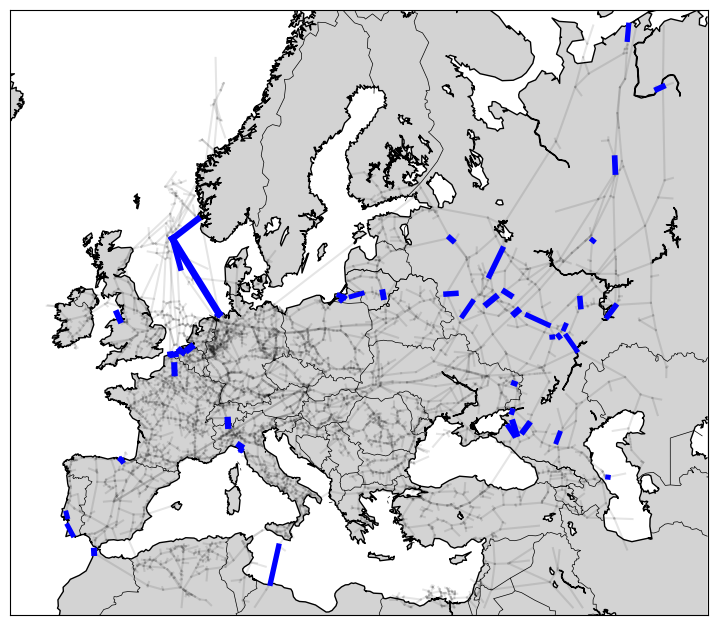

In [ ]:
plt.figure(figsize=(9, 10))

# Plot the map
m = Basemap(projection='merc', llcrnrlat=30, urcrnrlat=69, llcrnrlon=-15, urcrnrlon=60, resolution='l')
m.drawcoastlines()
m.drawcountries()
m.fillcontinents(color='lightgray')

# Get the maximum value of 'diff' for normalization
max_diff = edge_removals_df['diff'].max()

# Plot all the edges in G_simple_directed
for u, v in G_simple_directed.edges():
    x, y = m([G_simple_directed.nodes[u]['long'], G_simple_directed.nodes[v]['long']], [G_simple_directed.nodes[u]['lat'], G_simple_directed.nodes[v]['lat']])
    m.plot(x, y, 'k-', alpha=0.1)

# Plot the points themselves
edge_removals_df = edge_removals_df.iloc[1:]
for edge, diff in zip(edge_removals_df['removed_entity'], edge_removals_df['diff']):
    edge = tuple(edge)
    u, v = edge
    x, y = m([G_simple_directed.nodes[u]['long'], G_simple_directed.nodes[v]['long']], [G_simple_directed.nodes[u]['lat'], G_simple_directed.nodes[v]['lat']])
    # Adjust linewidth based on the value of 'diff'
    linewidth = 5*(diff / max_diff)**(1/20)
    m.plot(x, y, 'b-', linewidth=linewidth)

plt.savefig('saved_plots/heatmaps/'+analysis+'/edge_impact.png', bbox_inches='tight', pad_inches=0)
plt.savefig('latex_figures/' + analysis + '_edge_impact.svg', bbox_inches='tight', pad_inches=0)

plt.show()
